In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
from scipy.stats import gaussian_kde
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.models import Models
from tigramite.causal_effects import CausalEffects
import sklearn
from sklearn.linear_model import LinearRegression
import pickle
import pandas as pd


In [2]:
#denotes position in array above: X_1 = first sub-array; X_2 = second sub-array
X = [(0,0), (1,0)] 
Y = [(3,0)]
# Just for plotting purposes
var_names = ['$X_1$', '$X_2$', '$M$', '$Y$', '$Z_1$', '$Z_2$', '$Z_3$']

In [3]:
def lin_f(x): return x
coeff = .5
links_coeffs = {
                0: [], 
                1: [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)], 
                2: [((1, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
                3: [((1, 0), coeff, lin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
                4: [((5, 0), coeff, lin_f), ((7, 0), coeff, lin_f)], 
                5: [],
                6: [],
                7: [],
                }
T = 10000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)
# Time series no 7 is unobserved confounder
data = data[:, [0,1,2,3,4,5,6]]
dataframe = pp.DataFrame(data)



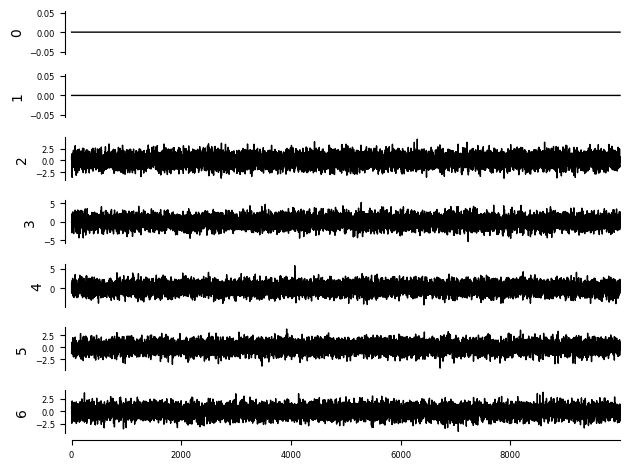

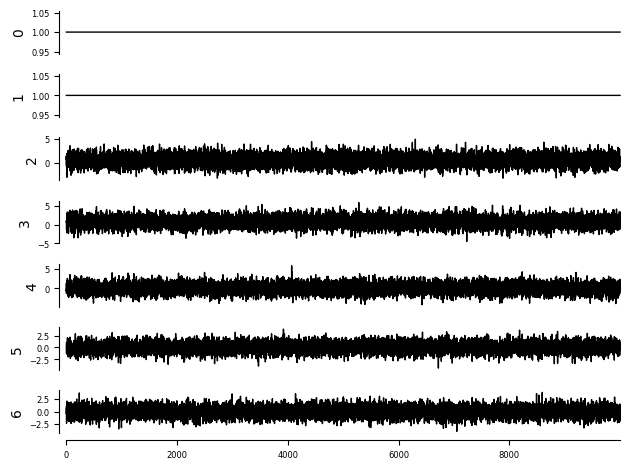

In [4]:
intervention2 = 0.*np.ones(T)
intervention_data2, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7,
                                            intervention={X[0][0]:intervention2, X[1][0]:intervention2}, 
                                            intervention_type='hard',)
# Time series no 7 is unobserved confounder
intervention_data2 = intervention_data2[:, [0,1,2,3,4,5,6]]
tp.plot_timeseries(pp.DataFrame(intervention_data2)); plt.show()

T = 10000
intervention1 = np.ones(T)
intervention_data1, nonstat = toys.structural_causal_process(
                                       links_coeffs, T=T, 
                                       noises=None, 
                                       seed=7,
                                       intervention={X[0][0]:intervention1, X[1][0]:intervention1}, 
                                       intervention_type='hard',)

# Time series no 7 is unobserved confounder
intervention_data1 = intervention_data1[:, [0,1,2,3,4,5,6]]
tp.plot_timeseries(pp.DataFrame(intervention_data1)); plt.show()

In [5]:
true_effect = (intervention_data1[:,Y[0][0]] - intervention_data2[:,Y[0][0]]).mean()
print("True effect = %.2f" %true_effect)

True effect = 0.75


In [14]:
df1 = pd.DataFrame(intervention_data1, columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
df1['x7'] = np.nan
df1.to_pickle('intervention_data1.pkl')


df1 = pd.DataFrame(intervention_data2, columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
df1['x7'] = np.nan
df1.to_pickle('intervention_data2.pkl')

In [7]:
#graph in the toy model
graph =  np.array([['', '-->', '', '', '', '', ''],
                   ['<--', '', '-->', '-->', '', '<--', ''],
                   ['', '<--', '', '-->', '', '<--', ''],
                   ['', '<--', '<--', '', '<->', '', '<--'],
                   ['', '', '', '<->', '', '<--', ''],
                   ['', '-->', '-->', '', '-->', '', ''],
                   ['', '', '', '-->', '', '', '']], dtype='<U3')

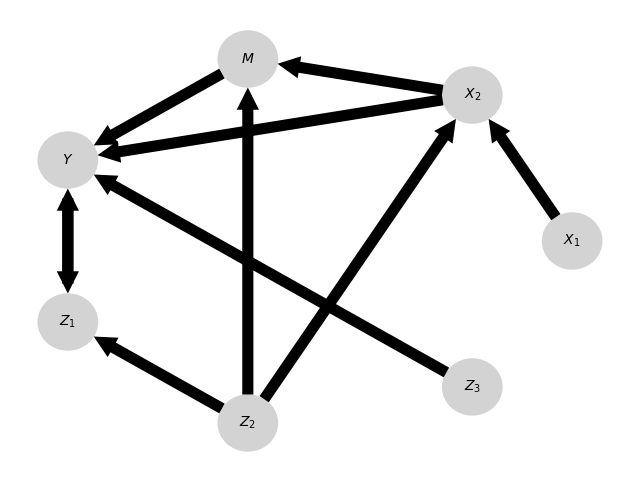

In [8]:
tp.plot_graph(graph = graph,
        var_names=var_names, 
        save_name='Example.pdf',
        figsize = (8, 6),
        ); plt.show()

In [9]:

#run CausalEffects
causal_effects = CausalEffects(graph, graph_type='admg', X=X, Y=Y, S=None, hidden_variables=None, verbosity=1)




##
## Initializing CausalEffects class
##

Input:

graph_type = admg
X = [(0, 0), (1, 0)]
Y = [(3, 0)]
S = []
M = [(2, 0)]





In [10]:
opt = causal_effects.get_optimal_set()
print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])

Oset =  [('$Z_1$', 0), ('$Z_2$', 0), ('$Z_3$', 0)]


In [11]:
causal_effects.fit_total_effect(
        dataframe=dataframe, 
        estimator=LinearRegression(),
        adjustment_set='optimal',
        conditional_estimator=None,  
        data_transform=None,
        mask_type=None,
        )

In [12]:
intervention_data = 1.*np.ones((1, 2))
y1 = causal_effects.predict_total_effect( 
        intervention_data=intervention_data
        )
print("y1 = ",y1)

intervention_data = 0.*np.ones((1, 2))
y2 = causal_effects.predict_total_effect( 
        intervention_data=intervention_data
        )
print("y2 = ",y2)

y1 =  [0.73288075]
y2 =  [-0.00799763]


In [13]:
beta = (y1 - y2)
print("Causal effect = %.2f" %(beta))

Causal effect = 0.74
